In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from ipywidgets import interact
import re
import markov_clustering as mc
import networkx as nx
import random

## Data preprocessing

### Read npi

In [ ]:
columns = ['NPI','Entity Type Code','Provider Last Name (Legal Name)','Provider First Name', 
'Provider Organization Name (Legal Business Name)','Provider Other Organization Name',
'Provider First Line Business Practice Location Address','Provider Second Line Business Practice Location Address',
'Provider Business Practice Location Address City Name','Provider Business Practice Location Address State Name',
'Provider Business Practice Location Address Postal Code',
'Healthcare Provider Primary Taxonomy Switch_1', 'Healthcare Provider Taxonomy Code_1',
'Healthcare Provider Primary Taxonomy Switch_2', 'Healthcare Provider Taxonomy Code_2',
'Healthcare Provider Primary Taxonomy Switch_3', 'Healthcare Provider Taxonomy Code_3',
'Healthcare Provider Primary Taxonomy Switch_4', 'Healthcare Provider Taxonomy Code_4',
'Healthcare Provider Primary Taxonomy Switch_5', 'Healthcare Provider Taxonomy Code_5',
'Healthcare Provider Primary Taxonomy Switch_6', 'Healthcare Provider Taxonomy Code_6',
'Healthcare Provider Primary Taxonomy Switch_7', 'Healthcare Provider Taxonomy Code_7',
'Healthcare Provider Primary Taxonomy Switch_8', 'Healthcare Provider Taxonomy Code_8',
'Healthcare Provider Primary Taxonomy Switch_9', 'Healthcare Provider Taxonomy Code_9',
'Healthcare Provider Primary Taxonomy Switch_10', 'Healthcare Provider Taxonomy Code_10',
'Healthcare Provider Primary Taxonomy Switch_11', 'Healthcare Provider Taxonomy Code_11',
'Healthcare Provider Primary Taxonomy Switch_12', 'Healthcare Provider Taxonomy Code_12',
'Healthcare Provider Primary Taxonomy Switch_13', 'Healthcare Provider Taxonomy Code_13',
'Healthcare Provider Primary Taxonomy Switch_14', 'Healthcare Provider Taxonomy Code_14',
'Healthcare Provider Primary Taxonomy Switch_15', 'Healthcare Provider Taxonomy Code_15',]

In [ ]:
def filter_primary_code(data):
    is_primary_switch = ((data['Healthcare Provider Primary Taxonomy Switch_1'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_2'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_3'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_4'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_5'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_6'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_7'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_8'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_9'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_10'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_11'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_12'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_13'] == 'Y')|(data['Healthcare Provider Primary Taxonomy Switch_14'] == 'Y')
      |(data['Healthcare Provider Primary Taxonomy Switch_15'] == 'Y'))
    
    data = data.loc[is_primary_switch, columns].fillna('NaN')
    
    data['Taxonomy_Code'] = ""

    for i in range(1,16):
        data['Taxonomy_Code'] = data['Taxonomy_Code'] + \
        data[f'Healthcare Provider Primary Taxonomy Switch_{i}'] + data[f'Healthcare Provider Taxonomy Code_{i}'] 
    
    data['Taxonomy_Code'] = [re.search(r'Y(\w{9}X)', x).group(1) for x in data.Taxonomy_Code]
    
    return data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,-1]]
    

In [ ]:
# specifying the converters can keep the leading zeros in the zip codes
# otherwise, the engine will read them as category object including floats and strings
chunks = (filter_primary_code(chunk) for chunk in pd.read_csv('data/npidata_pfile_20050523-20200209.csv', 
                                                              chunksize=1000, low_memory=False, 
                                                              converters={'Provider Business Practice Location Address Postal Code': str}))

npi = pd.concat(chunks)
del chunks

In [ ]:
npi.to_pickle('data/npi.pkl')

In [2]:
npi = pd.read_pickle('data/npi.pkl')

### Read hop_teaming

In [ ]:
# read hop_teaming as dask dataframe
hop_teaming = dd.read_csv('data/DocGraph_Hop_Teaming_2017.csv')

#### merge with nip data on the npi number to filter down to the reasonable size
- filter the from_npi to the type 1, which refers to the specialist (Orthopedic Surgeon, Cardiology, etc)
- filter the transaction_count and average_day_wait because the lower patient counts generally reflect random referrals and
high average day wait generally reflects “accidental” referrals
- filter the to_npi to the type 2, which refers to the orgnazations like hospitals

In [ ]:
npi_hop = hop_teaming.merge(npi, how='inner', left_on='from_npi', right_on='NPI')

In [ ]:
npi_hop = npi_hop[(npi_hop['Entity Type Code'] == 1) & (npi_hop['transaction_count'] > 50) & (npi_hop['average_day_wait'] <50)]

In [ ]:
npi_hop = npi_hop.drop(['NPI','Entity Type Code'], axis=1).merge(npi[['NPI','Entity Type Code']], how='inner', left_on='to_npi', right_on='NPI')

In [ ]:
npi_hop = npi_hop[npi_hop['Entity Type Code'] == 2].drop(['std_day_wait','NPI','Entity Type Code'], axis=1)

In [ ]:
# show the progress
pbar = ProgressBar()
pbar.register()

# .compute() will be excecuted untill the last computation is involved
npi_hop = npi_hop.compute()

In [ ]:
npi_hop.to_pickle('data/npi_hop.pkl')

In [3]:
npi_hop = pd.read_pickle('data/npi_hop.pkl')

### Read the crosswalk (taxonomy code to its speacialty)

In [4]:
cross = pd.read_csv('data/CROSSWALK_MEDICARE_PROVIDER_SUPPLIER_to_HEALTHCARE_PROVIDER_TAXONOMY.csv')

In [5]:
cross = cross.loc[cross['PROVIDER TAXONOMY DESCRIPTION'].str.contains('Allopathic & Osteopathic Physicians',na=False)]

In [6]:
cross['specialty'] = [re.sub(r'Allopathic & Osteopathic Physicians/',"",x).strip() for x in cross['PROVIDER TAXONOMY DESCRIPTION']]

#### filter the speacialty

In [7]:
# using back reference (\1) to capture the matched group
cross['specialty'] = [re.sub(r'Internal Medicine[,\/] (.+)', r"\1", x) if re.match('Internal Medicine',x) \
                         else re.sub(r'[,\/].+', "", x) for x in cross['specialty']]

In [8]:
cross.columns = [re.sub(r"\s", '_', x).lower() for x in cross.columns]

In [9]:
npi_specialty = npi_hop.merge(cross, how='inner', left_on='Taxonomy_Code', right_on='provider_taxonomy_code')

#### filter the zip code

In [10]:
npi_specialty['zip'] = npi_specialty['Provider Business Practice Location Address Postal Code'].str[0:5]

### Read cbsa 

In [11]:
cbsa = pd.read_csv('data/ZIP_CBSA_122019.csv', converters={'ZIP': str})

In [12]:
cbsa.columns = cbsa.columns.str.lower()

In [13]:
cbsa = cbsa.sort_values(['zip', 'bus_ratio'], ascending=[True, False])

In [14]:
# return the ones having the highest bus_ratio 
cbsa = cbsa.groupby('zip').first().reset_index()

#### to merge is to get the cbsa codes related to the zip codes

In [15]:
npi_specialty_cbsa = npi_specialty.merge(cbsa[['zip', 'cbsa']], how = 'inner', on = 'zip')

In [16]:
npi_specialty_cbsa = npi_specialty_cbsa.drop(columns=['Taxonomy_Code', 'medicare_specialty_code',
                                                      'medicare_provider/supplier_type_description',
                                                      'provider_taxonomy_description'])

## Explore the data questions

### 1. Within a local CBSA, show which hospitals specialists typically refer patients to

#### filter the specialties patients normally refer to by CBSA

In [17]:
n_specialty_hospital = \
npi_specialty_cbsa.groupby(['cbsa','to_npi',
                            'specialty']).agg({'patient_count': 'sum', 
                                              'average_day_wait': 'mean' }) \
                                    .sort_values(['patient_count', 'average_day_wait'], ascending=[False, True]).reset_index()

In [18]:
n_specialty_hospital = n_specialty_hospital.groupby(['cbsa','specialty']).first().reset_index()

#### to get the business names for the orgnazations

In [19]:
n_specialty_hospital = \
n_specialty_hospital.merge(npi[['NPI','Provider Organization Name (Legal Business Name)']], 
                           how='inner', left_on='to_npi', right_on='NPI').drop('NPI', axis=1)

In [21]:
n_specialty_hospital['Provider Organization Name (Legal Business Name)'] = \
n_specialty_hospital['Provider Organization Name (Legal Business Name)'] + '.'

#### filter the cbsa to Nashville

In [22]:
links = n_specialty_hospital[n_specialty_hospital.cbsa==34980][['specialty','Provider Organization Name (Legal Business Name)', 'patient_count']]

#### create the graph demonstrating how specialties frequently refer orgnazations by the count of patients (weight)

In [23]:
plt.rcParams['figure.figsize'] = (20,20)

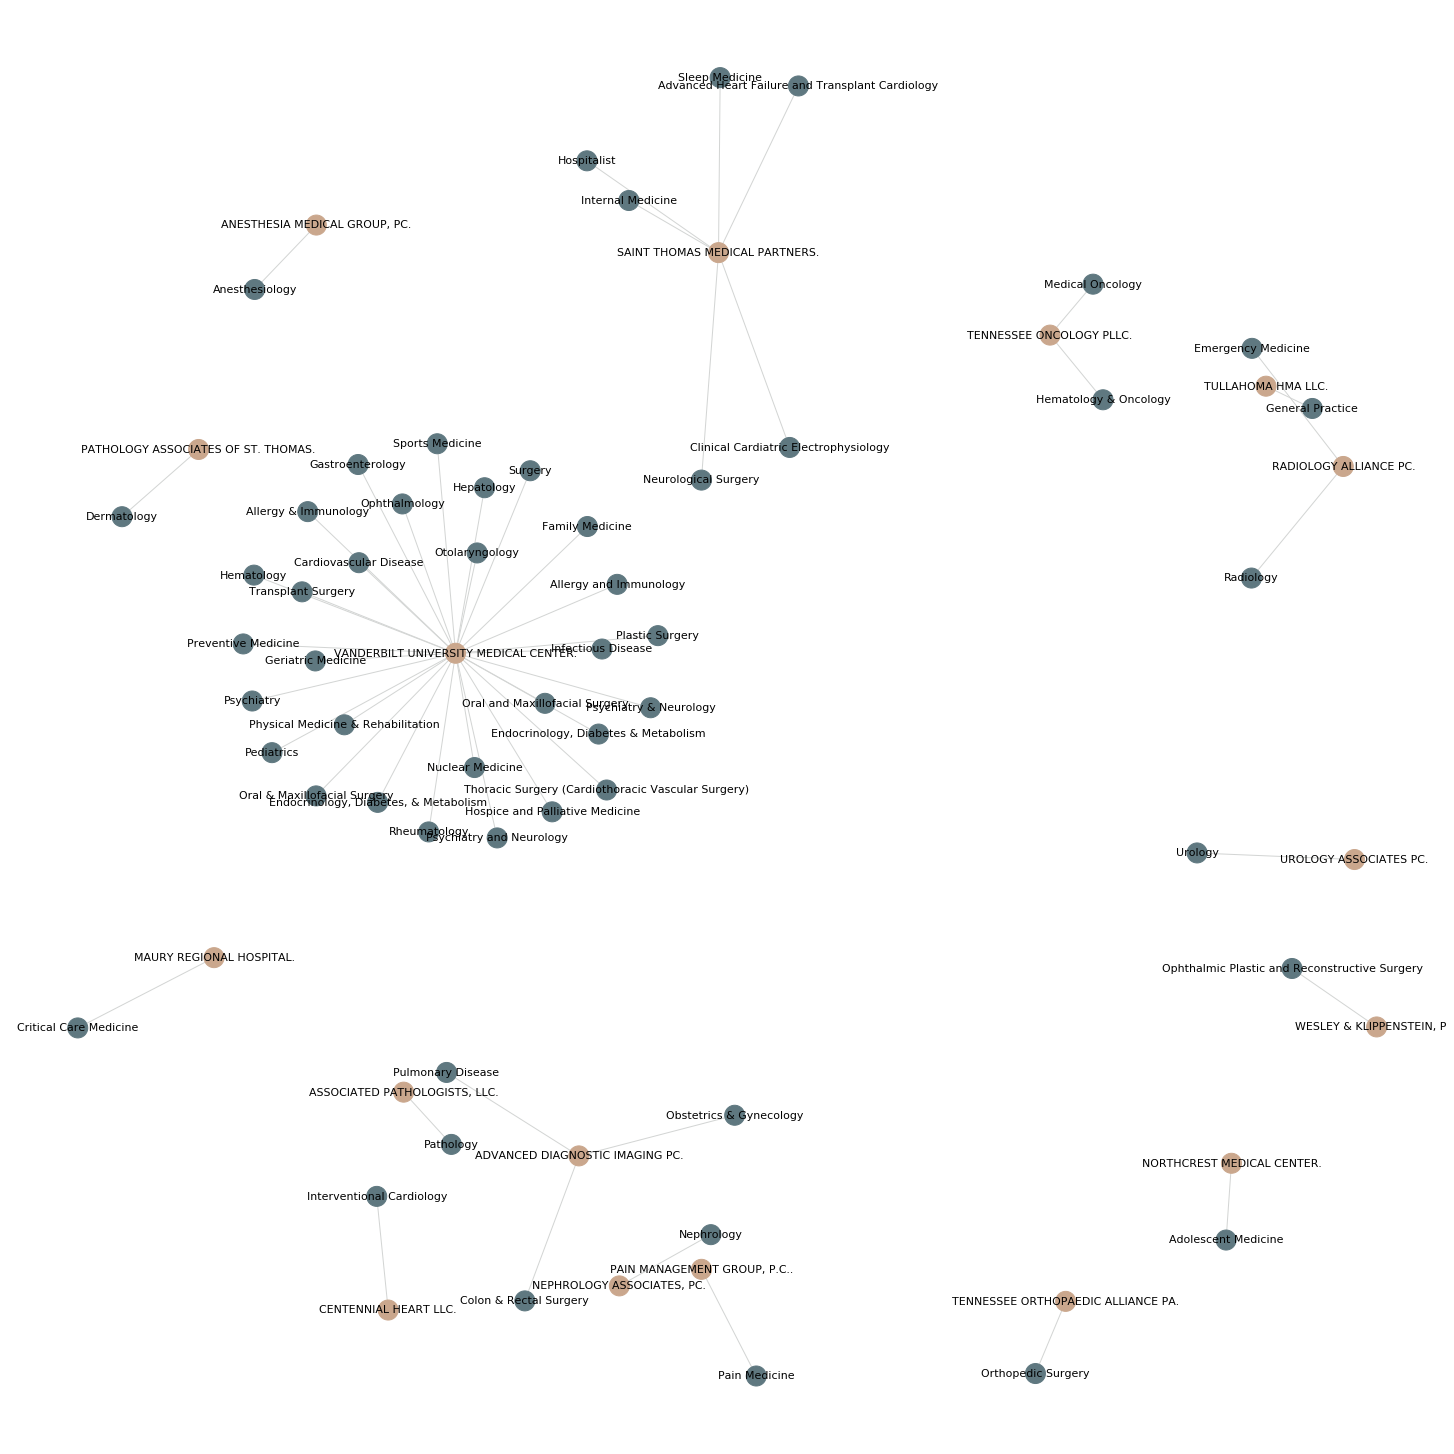

In [134]:
# Transform it in a links data frame (3 columns only):
links.columns = ['var1', 'var2','value']
links
 
# Build the graph
G=nx. from_pandas_edgelist(links, 'var1', 'var2')

color_map = []
for node in G:
    if '.' in node:
        color_map.append('#CAA78D')
    else: 
        color_map.append('#5F7880') 

# Plot the network:
nx.draw(G, with_labels=True, node_color=color_map, node_size=400, edge_color='#D3D5D4', 
        linewidths=1, font_size=11, pos = nx.spring_layout(G,k=0.20,iterations=30))

### 2. Analyze how facility type referrals differ by specialty (e.g. Do orthopedists refer to different types of facilities than cardiologists?)

In [24]:
ccn = pd.read_csv('data/ccn.csv', usecols=['Facility ID','Facility Name','Address','City','State',
                                           'ZIP Code','Hospital Type', 'Hospital Ownership'], converters = {'ZIP Code' : str})

In [25]:
ccn.columns = [re.sub(r"\s", '_', x).lower() for x in ccn.columns]

#### complete the leading zeros

In [26]:
def five_digit_zip (zip):
    while len(zip) < 5:
        zip = '0' + zip
    return zip

In [27]:
ccn.zip_code = [five_digit_zip(x) for x in ccn.zip_code]

#### form the unique key for CCN
- The candidate keys
    - Address (unique, but hard to standardize)
    - City (not unique and hard to standardize, e.g. s.t louis V.S staint louis)
    - State (unique, but state-to_npi could be one to many)
    - Zip (unique, but zip–to_npi could be one to many)
- The possible key (maximize the possibility of matching addresses)
    - The leading portions of the addresses + the first letter of the cities + state + zip 

In [29]:
npi_specialty_cbsa['Provider First Line Business Practice Location Address'] = \
    npi_specialty_cbsa['Provider First Line Business Practice Location Address'].str.lower()

In [30]:
#extract either the first digit-pattern or word-pattern
npi_specialty_cbsa['address_pattern'] = [re.search(r'\d+', x).group(0) if re.search(r'\d+', x) else re.search(r'\w+', x).group(0) \
                          for x in npi_specialty_cbsa['Provider First Line Business Practice Location Address']]

In [31]:
npi_specialty_cbsa['Provider Business Practice Location Address City Name'] = \
npi_specialty_cbsa['Provider Business Practice Location Address City Name'].str.lower()

In [32]:
npi_specialty_cbsa['city_pattern'] = [re.search(r'\w', x).group(0) \
                                      for x in npi_specialty_cbsa['Provider Business Practice Location Address City Name']]

In [33]:
ccn.address = ccn.address.str.lower()

In [34]:
ccn['address_pattern'] = [re.search(r'\d+', x).group(0) if re.search(r'\d+', x) else re.search(r'\w+', x).group(0) \
                          for x in ccn.address]

In [35]:
ccn.city =  ccn.city.str.lower()

In [36]:
ccn['city_pattern'] = [re.search(r'\w', x).group(0) for x in ccn.city]

In [37]:
facility_specialty = npi_specialty_cbsa.merge(ccn,  how='inner', 
                                        left_on=['Provider Business Practice Location Address State Name','zip',
                                                 'address_pattern', 'city_pattern'], 
                                        right_on = ['state','zip_code','address_pattern','city_pattern'])

In [38]:
specialty_by_type = facility_specialty.groupby(['specialty','hospital_type'])['patient_count'].sum().reset_index()

#### the majority of hospitals falls in the category so it is required to be filtered

In [40]:
specialty_by_type = specialty_by_type[specialty_by_type.hospital_type != 'Acute Care Hospitals']

In [41]:
@interact(specialty_1 = facility_specialty.specialty.unique().tolist(),
          specialty_2 = facility_specialty.specialty.unique().tolist())
def diff_type_specialty(specialty_1, specialty_2):

    data_1 = specialty_by_type[specialty_by_type.specialty == specialty_1]
    data_2 = specialty_by_type[specialty_by_type.specialty == specialty_2]
    
    fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(20,9),sharey = True)
    sns.barplot(ax = ax0, data = data_1, x ="hospital_type", y="patient_count", palette="Blues_d")
    sns.barplot(ax = ax1, data = data_2, x ="hospital_type", y="patient_count", palette="Blues_d")
    ax0.set_title("Facility type by" + ":" + specialty_1, fontsize=22)
    ax1.set_title("Facility type by" + ":" + specialty_2, fontsize=22)
    ax0.set_xlabel('hospital_type', fontsize=20)
    ax0.set_ylabel('count', fontsize=20)
    ax1.set_xlabel('hospital_type', fontsize=20)
    ax1.set_ylabel('count', fontsize=20)
    plt.sca(ax0)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xticks(rotation=90)
    plt.sca(ax1)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xticks(rotation=90)
  

interactive(children=(Dropdown(description='specialty_1', options=('Emergency Medicine', 'Internal Medicine', …